# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
import sqlite3
from google.colab import drive
drive.mount('/content/drive')
con = sqlite3.connect('/content/drive/My Drive/Asgn/database.sqlite')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:

# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 60000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (60000, 10)


Id  ...                                               Text
0   1  ...  I have bought several of the Vitality canned d...
1   2  ...  Product arrived labeled as Jumbo Salted Peanut...
2   3  ...  This is a confection that has been around a fe...

[3 rows x 10 columns]

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


UserId  ... COUNT(*)
0  #oc-R115TNMSPFT9I7  ...        2
1  #oc-R11D9D7SHXIJB9  ...        3
2  #oc-R11DNU2NBKQ23Z  ...        2
3  #oc-R11O5J5ZVQE25C  ...        3
4  #oc-R12KPBODL2B5ZD  ...        2

[5 rows x 7 columns]

In [8]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId  ... COUNT(*)
80638  AZY10LLTJ71NX  ...        5

[1 rows x 7 columns]

In [9]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id  ...                                               Text
0   78445  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1  138317  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2  138277  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3   73791  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4  155049  ...  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

[5 rows x 10 columns]

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(54458, 10)

In [13]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

90.76333333333334

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [14]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id  ...                                               Text
0  64422  ...  My son loves spaghetti so I didn't hesitate or...
1  44737  ...  It was almost a 'love at first bite' - the per...

[2 rows x 10 columns]

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(54456, 10)


1    45572
0     8884
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
My whole family loves this sauce. I use it primarily to recreate a dish we had in Maui. It adds a wonderful sweet and spicy flavor to just about any sauce. Service on this order was spectacular. Several bottles arrived broken and replacements were received within days. Amazon service was fast, easy and reliable. I love Amazon. Also, there are many recipes that you can look up using this sauce that a very good. It goes spectaculary with coconut milk, vegetables, chicken or shrimp and pasta. We love it.
My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he hasn't had a UTI for a year.
THIS BREAD MIX IS THE CLOSEST THING TO REGULAR BREAD I HAVE FOUND. EASY TO MAKE IN MY BREAD MACHINE.


In [18]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [19]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
My whole family loves this sauce. I use it primarily to recreate a dish we had in Maui. It adds a wonderful sweet and spicy flavor to just about any sauce. Service on this order was spectacular. Several bottles arrived broken and replacements were received within days. Amazon service was fast, easy and reliable. I love Amazon. Also, there are many recipes that you can look up using this sauce that a very good. It goes spectaculary with coconut milk, vegetables, chicken or shrimp and pasta. We love it.
My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he hasn't had a UTI for a year.
THIS BREAD MIX IS THE CLOSEST THING TO REGULAR BREAD I HAVE FOUND. EASY TO MAKE IN MY BREAD MACHINE.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

My husband is a paraplegic and was having UTIs constantly.  Since he started drinking a cup of this tea every morning, he has not had a UTI for a year.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

My husband is a paraplegic and was having UTIs constantly Since he started drinking a cup of this tea every morning he has not had a UTI for a year 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 54456/54456 [00:19<00:00, 2756.83it/s]


In [26]:
preprocessed_reviews[1500]

'husband paraplegic utis constantly since started drinking cup tea every morning not uti year'

In [0]:
final['cleanedText']=preprocessed_reviews

In [28]:
final.shape

(54456, 11)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

In [29]:
# Sorting data based on time
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final_df = final.sort_values(by = "Time")
print(final_df.shape)
final_df.head(5)

(54456, 11)


Id  ...                                        cleanedText
1146    1245  ...  really good idea final product outstanding use...
1145    1244  ...  received shipment could hardly wait try produc...
28086  30629  ...  nothing product bother link top page buy used ...
28087  30630  ...  love stuff sugar free not rot gums tastes good...
38740  42069  ...  fresh limes underappreciated joy kitchen squir...

[5 rows x 11 columns]

In [30]:
# 50k data which will use to train model after vectorization
X = final_df['cleanedText']
print("shape of X:", X.shape)
# class label
Y = final_df["Score"]
print("shape of Y:", Y.shape)

shape of X: (54456,)
shape of Y: (54456,)


In [0]:
# 60k data which will use to train model after vectorization
X1 = final_d['cleanedText']
print("shape of X:", X1.shape)

In [33]:
#Splitting data
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 52)
X_traincv, X_cv, y_traincv, y_cv = train_test_split(X_train, y_train, test_size=0.33)
print(X_train.shape, y_train.shape, x_test.shape)
print(X_traincv.shape, y_traincv.shape, y_cv.shape)

(38119,) (38119,) (16337,)
(25539,) (25539,) (12580,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [34]:
#BoW
count_vect = CountVectorizer(min_df = 10) #in scikit-learn
bowt=count_vect.fit_transform(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bowts = count_vect.transform(x_test)
print("the type of count vectorizer ",type(bowts))
print("the shape of out text BOW vectorizer ",bowts.get_shape())
print("the number of unique words ", bowts.get_shape()[1])

some feature names  ['ability', 'able', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs', 'abundance']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (16337, 7626)
the number of unique words  7626


## [4.3] TF-IDF

In [35]:
#, max_features=5000
tf_idf_vect = TfidfVectorizer()
tfidft=tf_idf_vect.fit_transform(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names())
print('='*50)

tfidfts = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(tfidft))
print("the shape of out text TFIDF vectorizer ",tfidft.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidft.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaah', 'aaah', 'aadp', 'aafco', 'aah', 'aahhhs', 'aahs', 'aasanfood', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abates', 'abberline', 'abbey', 'abbott', 'abbreviated', 'abbreviation', 'abby', 'abc', 'abcessed', 'abdomen', 'abdominal', 'abhor', 'abhors', 'abid', 'abide', 'abiding', 'abig', 'abilities', 'ability', 'abilling', 'abit', 'ablaze', 'able', 'ablity', 'abnormal', 'abnormalities', 'abnormally', 'abnoxious', 'aboard', 'abode', 'abomination', 'abominations', 'aboout', 'abor', 'aboslutely', 'abosoutely', 'abou', 'aboulutely', 'abound', 'abounds', 'abour', 'aboutamazon', 'aboutthe', 'abovei', 'aboveour', 'abovethirst', 'aboviously', 'abowl', 'abowt', 'abraded', 'abrasions', 'abrasive', 'abreast', 'abroad', 'abrubt', 'abrupt', 'abruptness', 'abs', 'absalutely', 'absconded', 'absence', 'absense', 'absent', 'absentmindedly', 'absinthe', 'absoletly', 'absoloutely', 'a

## [4.4] Word2Vec

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [36]:
X = final_df['cleanedText']
print("shape of X:", X.shape)

shape of X: (54456,)


In [0]:
#X = final_df["Text"]
#X.shape

(50000,)

In [0]:
import re
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:
import gensim
list_of_sent=[]
for sent in X:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [37]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  13942
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'screens', 'computer', 'nothing', 'bother', 'link', 'top', 'page']


In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(len(sent_vectors_tr[0]))

100%|██████████| 54456/54456 [01:25<00:00, 635.80it/s]

54456


In [39]:
# Convert data list to an array
from sklearn.preprocessing import StandardScaler
Xavg = np.array(sent_vectors)
std = StandardScaler(with_mean = False)
std_xavg = std.fit_transform(Xavg)
std_xavg.shape

(54456, 50)

#### [4.4.1.2] TFIDF weighted W2v

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm( list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 54456/54456 [17:33<00:00, 51.70it/s]


In [0]:
from sklearn import preprocessing
xtfidf = preprocessing.normalize(tfidf_sent_vectors)
#print(tfidf_sent_vectors.shape)

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [0]:
k = [2,3,4,5,6,7,8,9,10]
inertia = []
for i in k:
    kmeans = KMeans(n_clusters=i, n_jobs=-1,init='k-means++', max_iter=100, n_init=1)
    kmeans.fit(bowt)
    inertia.append(kmeans.inertia_)

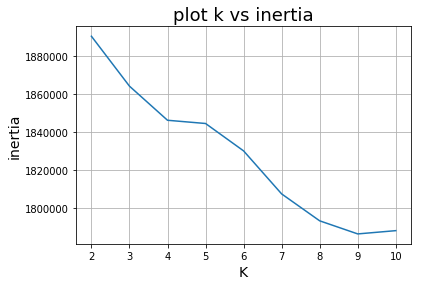

In [0]:
# Draw Loss VS K values plot
plt.plot(k, inertia)
plt.xlabel('K',size=14)
plt.ylabel('inertia',size=14)
plt.title('plot k vs inertia',size=18)
plt.grid()
plt.show()

In [0]:
kmeans = KMeans(n_clusters=4, n_jobs=-1)
kmeans.fit(bowt)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
#Plot each cluster features in a cloud
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
def plot_cluster_cloud(features, coef):
    coef_df = pd.DataFrame(coef, columns = features)
    print(len(coef_df))
    # Create a figure and set of 15 subplots because our k range is in between 
    fig, axes = plt.subplots(4, 1, figsize = (10, 15))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 30)
    cent = range(len(coef_df))
    for ax, i in zip(axes.flat, cent):
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
        ax.imshow(wordcloud)
        ax.set_title("Cluster {} word cloud".format(i+1), fontsize = 30)
        ax.axis("off")
    plt.tight_layout()
    fig.subplots_adjust(top = 0.90)
    plt.show()

4


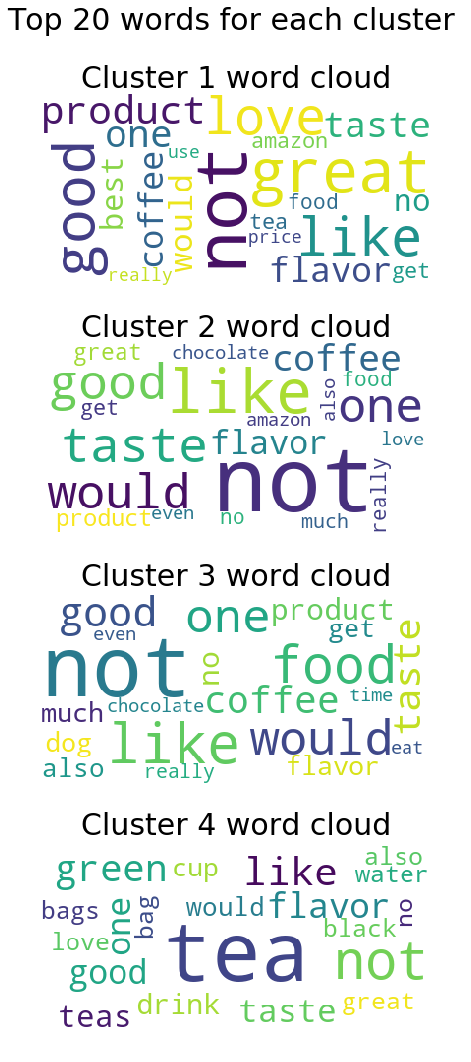

In [0]:
features = count_vect.get_feature_names()
coef = kmeans.cluster_centers_
plot_cluster_cloud(features, coef)

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
top=[]
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-10]
terms = count_vect.get_feature_names()
for j in range(4):
     print("Cluster %d:" % j, end='')
     for ind in order_centroids[j, :4]:
         print(' %s' % terms[ind], end='')
         print()
         top=terms.append(terms[ind])
          


Top terms per cluster:
Cluster 0: not
 would
 time
 well
Cluster 1: not
 get
 tried
 sugar
Cluster 2: not
 flavor
 little
 could
Cluster 3: tea
 cup
 use
 well


### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
k1 = [2,3,4,5,6,7,8,9,10]
inertia = []
for i in k1:
    kmeans1 = KMeans(n_clusters=i, n_jobs=-1,init='k-means++', max_iter=100, n_init=1)
    kmeans1.fit(tfidft)
    inertia.append(kmeans1.inertia_)

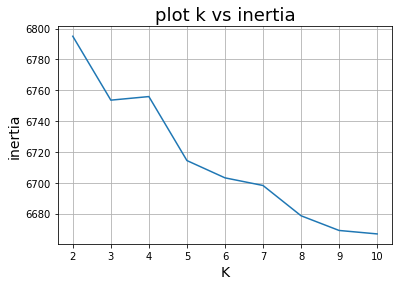

In [0]:
# Draw Loss VS K values plot
plt.plot(k1, inertia)
plt.xlabel('K',size=14)
plt.ylabel('inertia',size=14)
plt.title('plot k vs inertia',size=18)
plt.grid()
plt.show()

In [0]:
optk=3
kmeans1 = KMeans(n_clusters=optk, n_jobs=-1,init='k-means++', max_iter=100, n_init=1)
kmeans1.fit(tfidft)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=1, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
print("Top terms per cluster:")
order_centroids = kmeans1.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vect.get_feature_names()
for i in range(optk):
    print ("Cluster %d:" % i,)
    for ind in order_centroids[i, :10]:
      #print("Cluster %d:" % terms[ind], end=" ")
        print (' %s' % terms[ind],)
       
    print()

Top terms per cluster:
Cluster 0:
 not
 great
 good
 like
 product
 taste
 love
 one
 would
 flavor

Cluster 1:
 tea
 green
 not
 teas
 drink
 flavor
 good
 taste
 like
 love

Cluster 2:
 coffee
 not
 cup
 flavor
 like
 good
 great
 strong
 taste
 bold



In [0]:
#Plot each cluster features in a cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
def plot_cluster_cloud1(features, coef):
    coef_df = pd.DataFrame(coef, columns = features)
    print(len(coef_df))
    # Create a figure and set of 15 subplots because our k range is in between 
    fig, axes = plt.subplots(3, 1, figsize = (10, 15))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 30)
    cent = range(len(coef_df))
    for ax, i in zip(axes.flat, cent):
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
        ax.imshow(wordcloud)
        ax.set_title("Cluster {} word cloud".format(i+1), fontsize = 30)
        ax.axis("off")
    plt.tight_layout()
    fig.subplots_adjust(top = 0.90)
    plt.show()

In [0]:
features = tf_idf_vect.get_feature_names()
coef = kmeans1.cluster_centers_


3


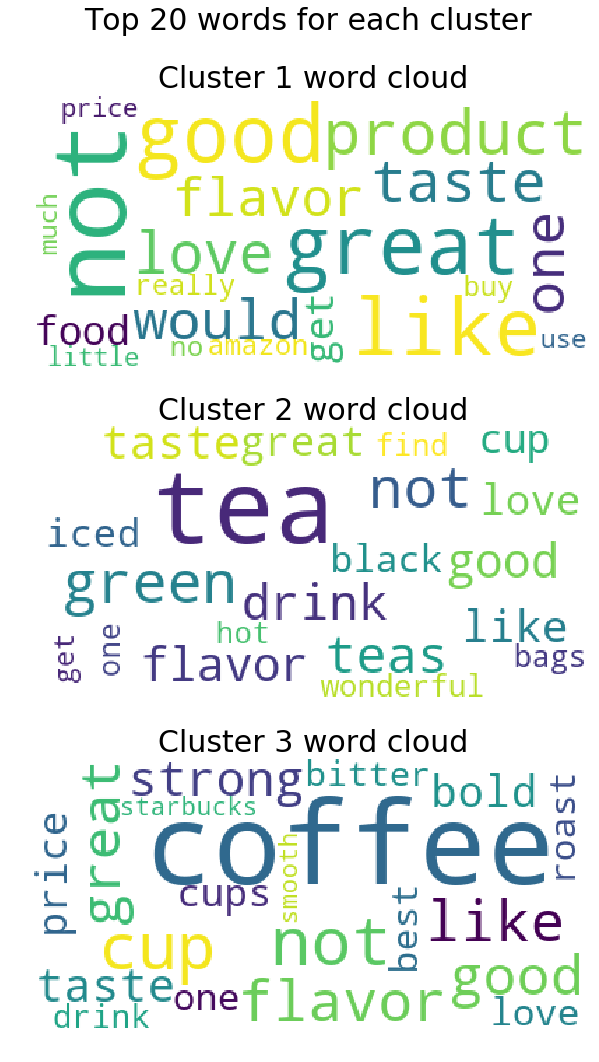

In [0]:
plot_cluster_cloud1(features, coef)

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
k = [2,3,4,5,6,7,8,9,10]
inertia2 = []
for i in k:
    kmeans2 = KMeans(n_clusters=i, n_jobs=-1,init='k-means++', max_iter=100, n_init=1)
    kmeans2.fit(std_xavg)
    inertia2.append(kmeans2.inertia_)

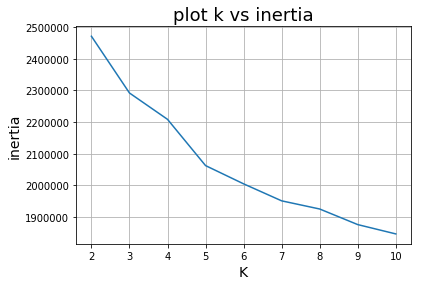

In [0]:
# Draw Loss VS K values plot
plt.plot(k, inertia2)
plt.xlabel('K',size=14)
plt.ylabel('inertia',size=14)
plt.title('plot k vs inertia',size=18)
plt.grid()
plt.show()

In [0]:
optimal2=5
kmeans2 = KMeans(n_clusters=optimal2)
kmeans2.fit(std_xavg)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [0]:
#Improvised code from Git ND gOOGLE SEARCH

In [0]:
final["cluster_label"] = kmeans2.labels_

In [0]:
from wordcloud import WordCloud, STOPWORDS 
def plot_word_cloud(txt):
    # store each word from review
    cloud = " ".join(word for word in txt)
    cloud
    # Remove duplicate words
    stopword = set(STOPWORDS) 
    # call built-in method WordCloud for creating an object for drawing a word cloud 
    stopwords = stopword
    wordcloud = WordCloud(width = 1500, height = 500, background_color ='blue',stopwords = stopword ).generate(cloud)
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off") 
    plt.title("World cloud of top words")
    plt.tight_layout(pad = 0)
  
    plt.show()

Total number of review in cluster 0 is: 9599


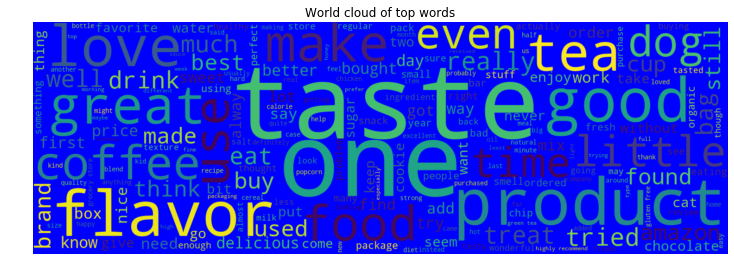

Total number of review in cluster 1 is: 12043


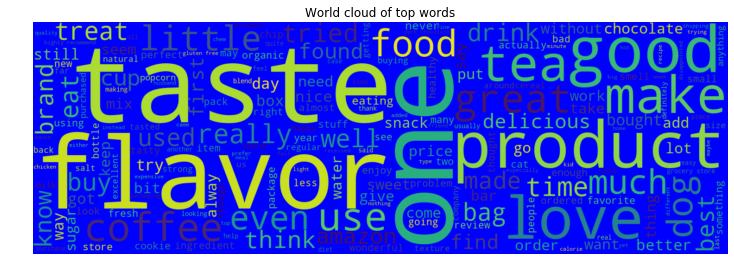

Total number of review in cluster 2 is: 7731


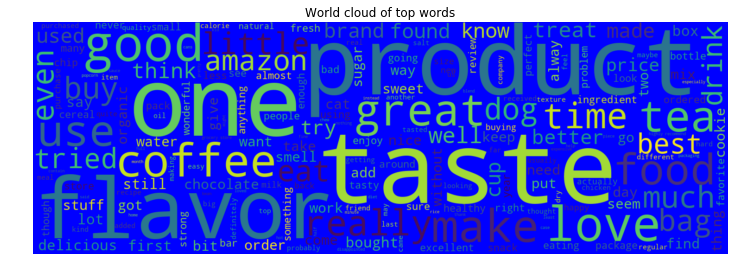

Total number of review in cluster 3 is: 13281


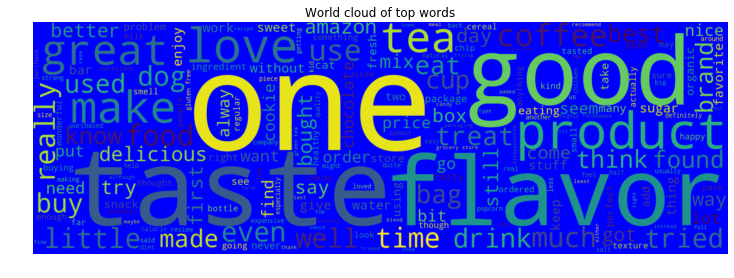

Total number of review in cluster 4 is: 11802


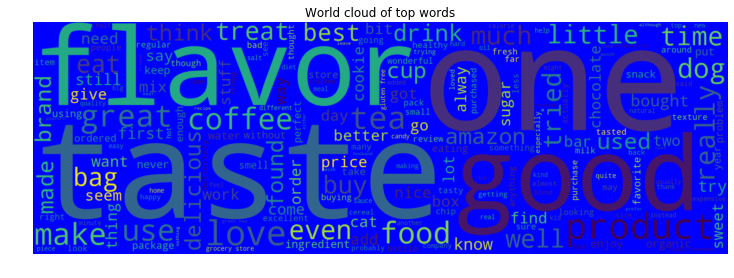

In [0]:
# For each cluster, group with its corresponding label.
for i in range(kmeans2.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["cleanedText"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    # Call plot_word_cloud method to plot review in each cluster 
    plot_word_cloud(l)

In [0]:
# Please write all the code with proper documentation

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
k = [2,3,4,5,6,7,8,9,10]
inertia3 = []
for i in k:
    kmeans3 = KMeans(n_clusters=i, n_jobs=-1,init='k-means++', max_iter=100, n_init=1)
    kmeans3.fit(xtfidf)
    inertia3.append(kmeans3.inertia_)

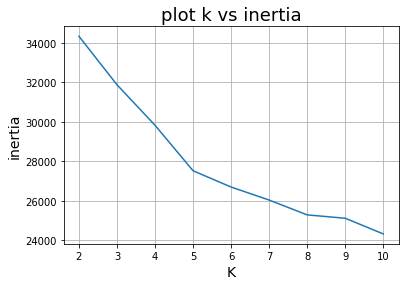

In [0]:
# Draw Loss VS K values plot
plt.plot(k, inertia3)
plt.xlabel('K',size=14)
plt.ylabel('inertia',size=14)
plt.title('plot k vs inertia',size=18)
plt.grid()
plt.show()

In [0]:
optimal3=5
kmeans3 = KMeans(n_clusters=optimal3, n_jobs=-1,init='k-means++', max_iter=100, n_init=1)
kmeans3.fit(xtfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=5, n_init=1, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
final["cluster_label"] = kmeans3.labels_

In [0]:
from wordcloud import WordCloud, STOPWORDS 
def plot_word_cloud1(txt):
    # store each word from review
    cloud = " ".join(word for word in txt)
    cloud
    # Remove duplicate words
    stopword = set(STOPWORDS) 
    # call built-in method WordCloud for creating an object for drawing a word cloud 
    stopwords = stopword
    wordcloud = WordCloud(width = 1500, height = 600, background_color ='white',stopwords = stopword ).generate(cloud)
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off") 
    plt.title("World cloud of top words")
    plt.tight_layout(pad = 0)
  
    plt.show()

Total number of review in cluster 0 is: 12097


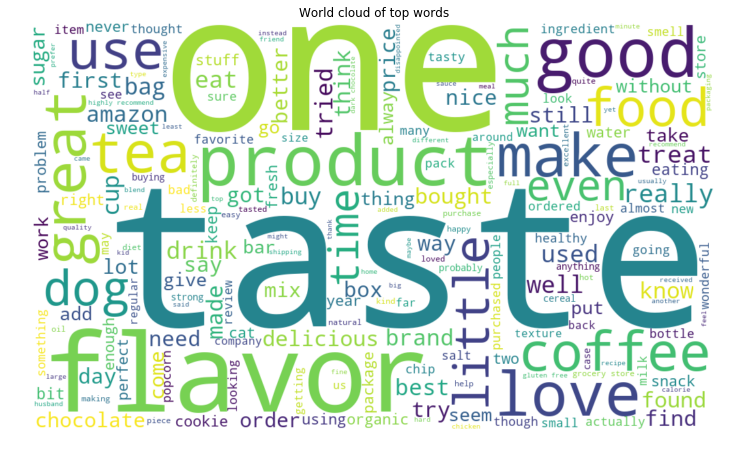

Total number of review in cluster 1 is: 9699


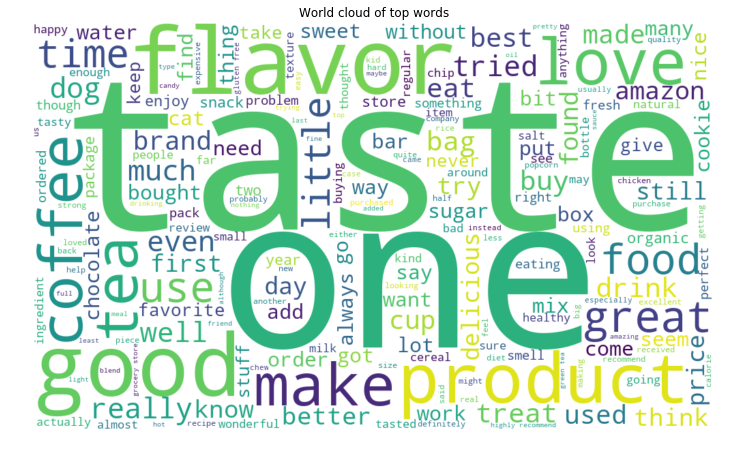

Total number of review in cluster 2 is: 10843


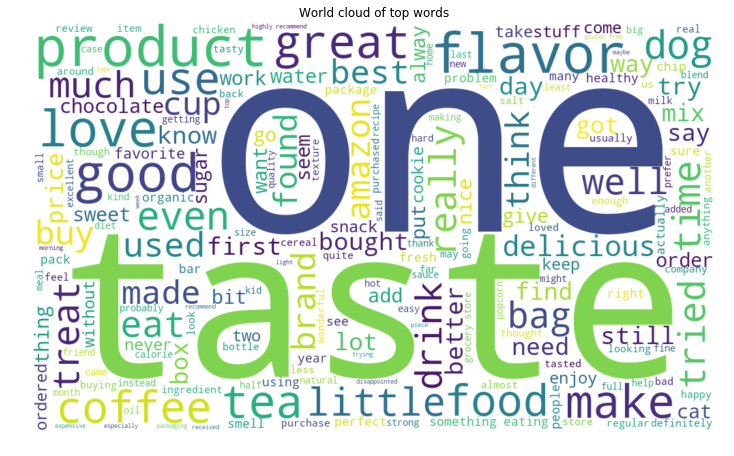

Total number of review in cluster 3 is: 8215


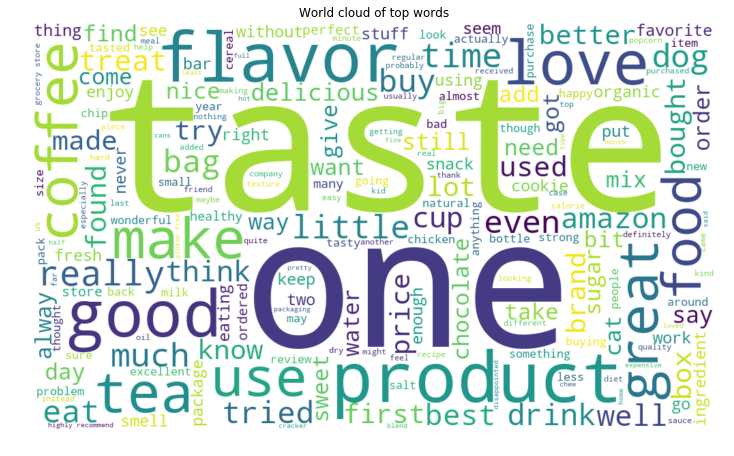

Total number of review in cluster 4 is: 13602


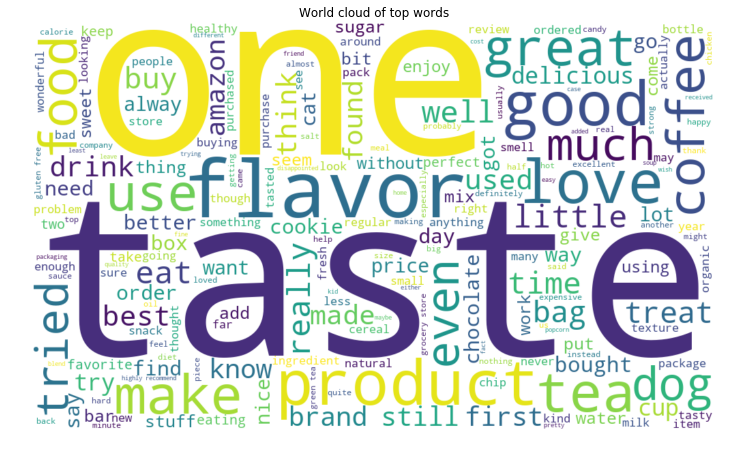

In [0]:
# For each cluster, group with its corresponding label.
for i in range(kmeans3.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["cleanedText"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    # Call plot_word_cloud method to plot review in each cluster 
    plot_word_cloud1(l)

## [5.2] Agglomerative Clustering

In [38]:
#Taking random 60000 points

final_data = final.sample(n=7000)

final_data.shape

(7000, 11)

In [39]:
# Sorting data based on time
final_data["Time"] = pd.to_datetime(final_data["Time"], unit = "s")
final_d = final_data.sort_values(by = "Time")
print(final_d.shape)
final_d.head(5)

(7000, 11)


Id  ...                                        cleanedText
1146    1245  ...  really good idea final product outstanding use...
38888  42226  ...  blend one starbucks gentler blends like taste ...
39671  43130  ...  discovered oils years ago bought one flavor th...
36853  40043  ...  get sauce first time would take edge toothpick...
17537  19119  ...  best sandwich topping ever grew eating bransto...

[5 rows x 11 columns]

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [40]:
X1 = final_d['cleanedText']
print("shape of X:", X1.shape)

shape of X: (7000,)


In [0]:
import gensim
list_of_sentx=[]
for sent in X1:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sentx.append(filtered_sentence)

In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentx,min_count=5,size=50, workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)

In [45]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectorsx = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentx): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectorsx.append(sent_vec)
print(len(sent_vectorsx))
#print(len(sent_vectors_tr[0]))

100%|██████████| 7000/7000 [00:06<00:00, 1042.43it/s]

7000


In [46]:
# Convert data list to an array
from sklearn.preprocessing import StandardScaler
Xagg = np.array(sent_vectorsx)
std = StandardScaler(with_mean = False)
std_Xagg = std.fit_transform(Xagg)
std_Xagg.shape

(7000, 50)

In [0]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters = 5,linkage='complete', 
                              affinity='euclidean', 
                             ).fit(std_Xagg)
model =agg.fit_predict(std_Xagg)

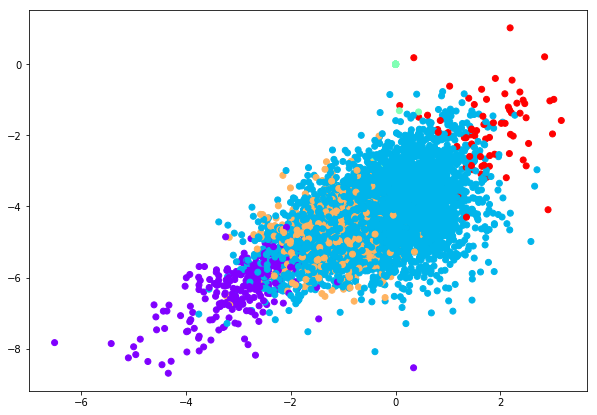

In [54]:
plt.figure(figsize=(10, 7))  
plt.scatter(std_Xagg[:,0], std_Xagg[:,1], c=agg.labels_, cmap='rainbow') 

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
final_d["cluster_label"] = agg.labels_

In [0]:
from wordcloud import WordCloud, STOPWORDS 
def plot_word_cloud2(txt):
    # store each word from review
    cloud = " ".join(word for word in txt)
    cloud
    # Remove duplicate words
    stopword = set(STOPWORDS) 
    # call built-in method WordCloud for creating an object for drawing a word cloud 
    stopwords = stopword
    wordcloud = WordCloud(width = 1000, height = 600, background_color ='black',stopwords = stopword ).generate(cloud)
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off") 
    plt.title("World cloud of top words")
    plt.tight_layout(pad = 0)
  
    plt.show()

Total number of review in cluster 0 is: 304


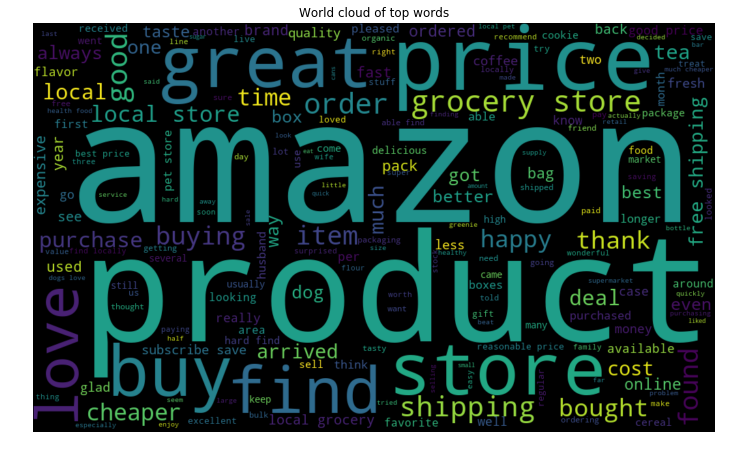

Total number of review in cluster 1 is: 5651


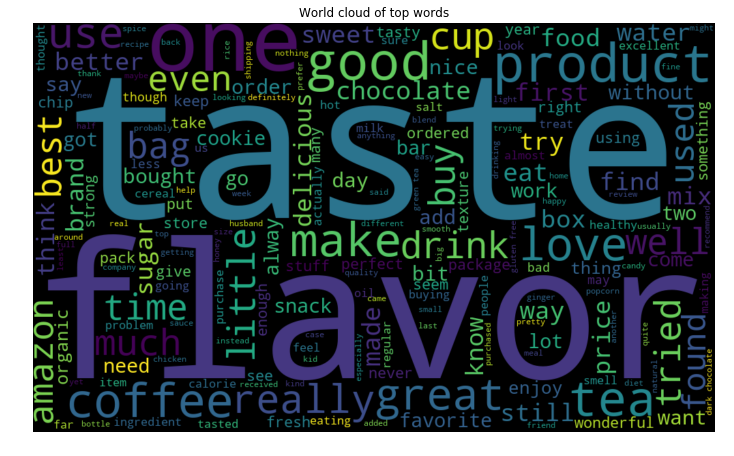

Total number of review in cluster 2 is: 28


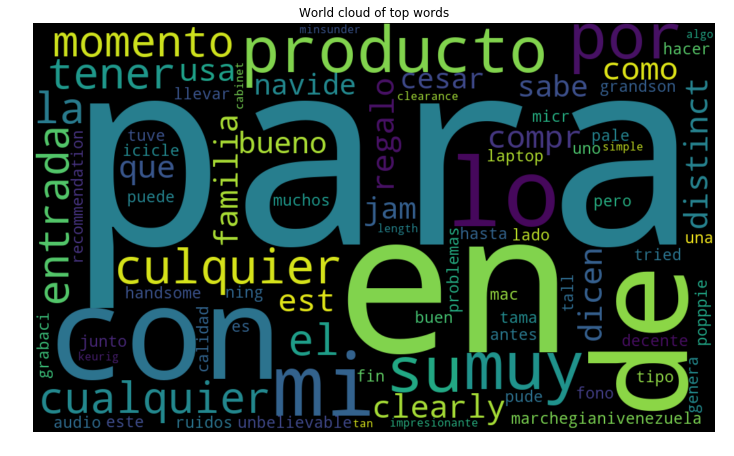

Total number of review in cluster 3 is: 948


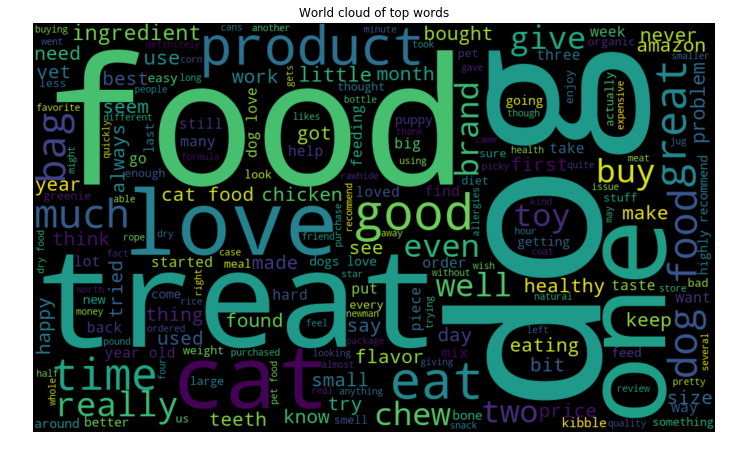

In [57]:
# Same as average word2vec of k means clustering
for i in range(4):
    l = list()
    label = final_d.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final_d.loc[label[j]]["cleanedText"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud2(l)

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X1)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [49]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectorsx = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm( list_of_sentx): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectorsx.append(sent_vec)
    row += 1

100%|██████████| 7000/7000 [00:56<00:00, 124.15it/s]


In [50]:
# Convert data list to an array and standardizing data
from sklearn.preprocessing import StandardScaler
agtf = np.array(sent_vectorsx)
std = StandardScaler(with_mean = False)
std_agtf = std.fit_transform(agtf)
std_agtf.shape

(7000, 50)

In [0]:
from sklearn.cluster import AgglomerativeClustering
agg1 = AgglomerativeClustering(n_clusters = 3,linkage='complete', 
                              affinity='euclidean', 
                             ).fit(std_agtf)
model =agg1.fit_predict(std_agtf)

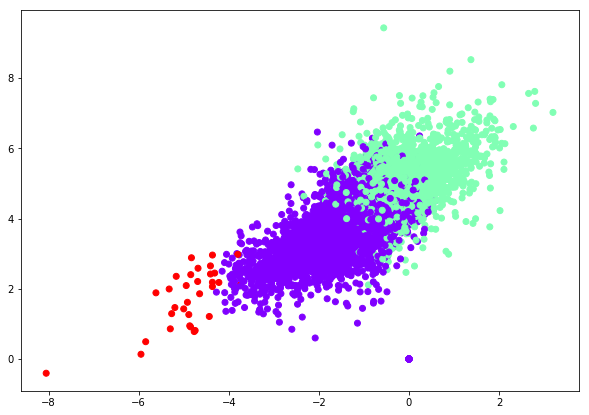

In [0]:
plt.figure(figsize=(10, 7))  
plt.scatter(std_agtf[:,0], std_agtf[:,1], c=agg1.labels_, cmap='rainbow') 

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
final_d["cluster_label"] = agg1.labels_

Total number of review in cluster 0 is: 4871


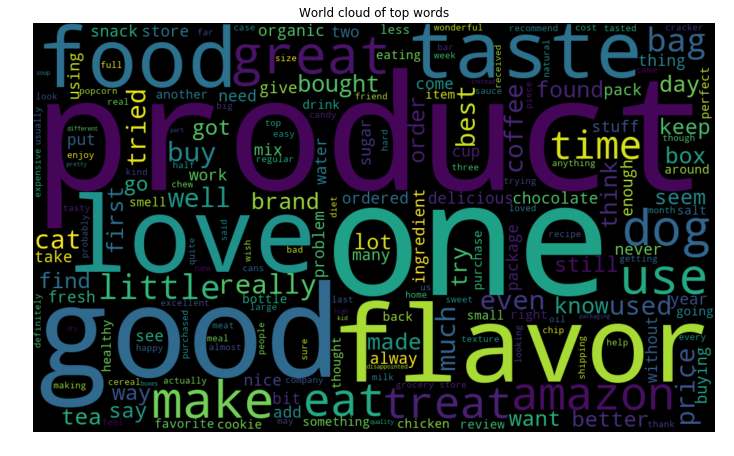

Total number of review in cluster 1 is: 2097


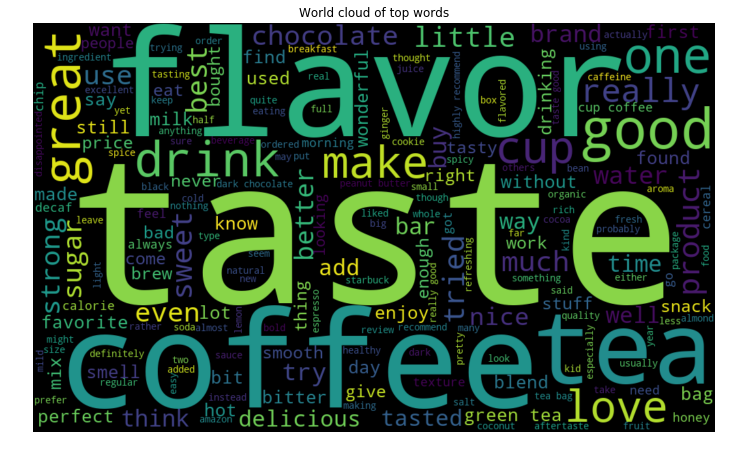

Total number of review in cluster 2 is: 32


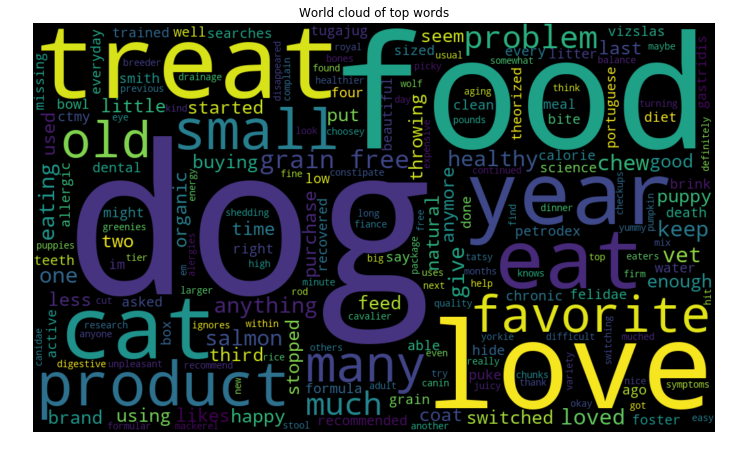

In [0]:
# Same as average word2vec of k means clustering
for i in range(3):
    l = list()
    label = final_d.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final_d.loc[label[j]]["cleanedText"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud2(l)

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

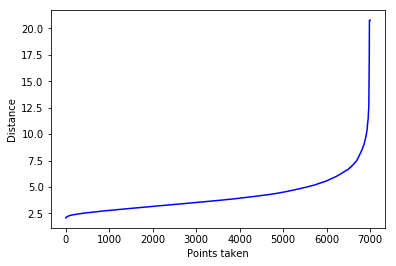

In [72]:
#Using KNN as its easy to find distance b\n nearest neifgbhbours 
#Code used from search
#https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
min_point = 150
knn = NearestNeighbors(n_neighbors = min_point)
knn.fit(std_Xagg)
dist , index = knn.kneighbors(std_Xagg)

#Plotting 
Align = sorted(dist[:,min_point-1])
plt.plot(list(range(1,len(std_Xagg)+1)),Align,'b-')
plt.xlabel("Points taken")
plt.ylabel("Distance")
plt.show()

In [0]:
#https://towardsdatascience.com/dbscan-clustering-for-data-shapes-k-means-cant-handle-well-in-python-6be89af4e6ea
#https://medium.com/@elutins/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818
#Plotting based on elbow plot
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(std_Xagg)
# cluster the data into five clusters
dbscan = DBSCAN(eps=6.5, min_samples = 2)
dbfit = dbscan.fit(X_scaled)
dbp = dbscan.fit_predict(X_scaled)

In [0]:
label = dbfit.labels_

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
final_d["cluster_label"] = dbfit.labels_

Total number of review in cluster 0 is: 6965


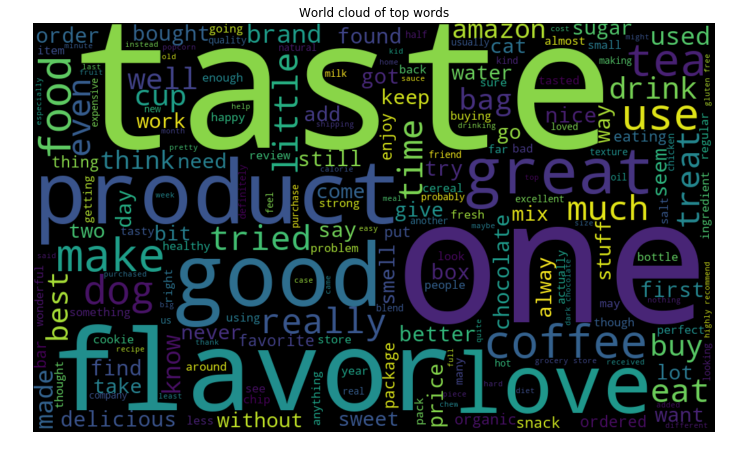

In [76]:
for i in range(1):
    l = list()
    label = final_d.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final_d.loc[label[j]]["cleanedText"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud2(l)

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

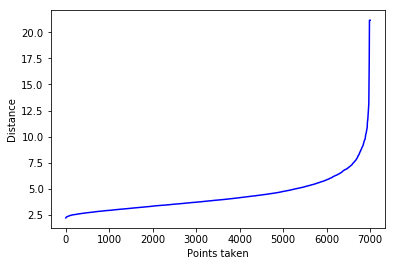

In [78]:
#https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
min_point = 200
knn = NearestNeighbors(n_neighbors = min_point)
knn.fit(std_agtf)
dist , index = knn.kneighbors(std_agtf)
#plotting elbow
Align = sorted(dist[:,min_point-1])
plt.plot(list(range(1,len(std_agtf)+1)),Align,'b-')
plt.xlabel("Points taken")
plt.ylabel("Distance")
plt.show()

In [0]:
#https://towardsdatascience.com/dbscan-clustering-for-data-shapes-k-means-cant-handle-well-in-python-6be89af4e6ea
#https://medium.com/@elutins/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818
#Plotting based on elbow plot
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(std_agtf)
# cluster the data into five clusters
dbscan = DBSCAN(eps=6, min_samples = 2)
dbfit1 = dbscan.fit(X_scaled)
dbp = dbscan.fit_predict(X_scaled)


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

In [0]:
final_d["cluster_label"] = dbfit1.labels_

Total number of review in cluster 0 is: 6956


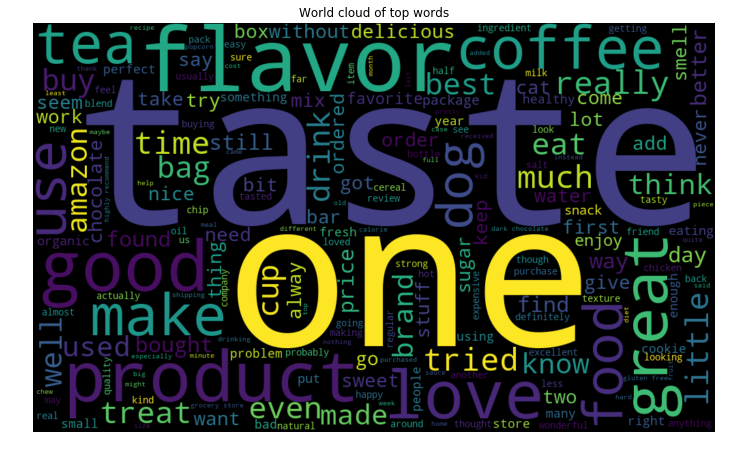

In [71]:
for i in range(1):
    l = list()
    label = final_d.groupby(["cluster_label"]).groups[i]
    for j in range(len(label)):
        l.append(final_d.loc[label[j]]["cleanedText"])
    print("Total number of review in cluster {} is: {}".format(i, len(label)))
    plot_word_cloud2(l)

# [6] Conclusions

In [89]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Type of clustering", "Model","Clusters",]
x.add_row(["K-means","Bow",4, ])
x.add_row(["K-means","TFIDF",3, ])
x.add_row(["K-means","Avg w2v",5, ])
x.add_row(["K-means","TFIDF w2v",5, ])
x.add_row(["Agglomerative","Avg w2v",5, ])
x.add_row(["Agglomerative","TFIDF w2v",3, ])

print(x)

+--------------------+-----------+----------+
| Type of clustering |   Model   | Clusters |
+--------------------+-----------+----------+
|      K-means       |    Bow    |    4     |
|      K-means       |   TFIDF   |    3     |
|      K-means       |  Avg w2v  |    5     |
|      K-means       | TFIDF w2v |    5     |
|   Agglomerative    |  Avg w2v  |    5     |
|   Agglomerative    | TFIDF w2v |    3     |
+--------------------+-----------+----------+


In [87]:
x1 = PrettyTable()
x1.field_names = ["Type of clustering", "Model","Epsilon value",]
x1.add_row(["DBSacan","Avg w2v", 6, ])
x1.add_row(["DBSacan","TFIDF w2v", 6, ])

print(x1)

+--------------------+-----------+---------------+
| Type of clustering |   Model   | Epsilon value |
+--------------------+-----------+---------------+
|      DBSacan       |  Avg w2v  |       6       |
|      DBSacan       | TFIDF w2v |       6       |
+--------------------+-----------+---------------+


# Observations


* Kmeams , agglomerative and DBScan clusters are trained.
*   Used 60K datapoints for k means.
*   Since its random dataset biased clusters are not produced.
*   Positive reviews are clusterd in most of the clusters.
*  7K datapoints used for Heirarchial clustering methods.
* Elbow plot of disatnce and points used for epsilon selection.
*   Wordcloud is printed for each of the models.
*   Clusters are taken based on elbow plot .
*  Performance is better.

